In [1]:
import pandas as pd
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import datetime
import cvxpy as cp
from pypfopt import EfficientFrontier
from pypfopt import EfficientCVaR
from pypfopt.plotting import plot_efficient_frontier


In [2]:
def variance(w, cov):
    return np.dot(w.T, np.dot(cov,w))

def returns(w, exp):
    return np.dot(w.T, exp)

# Process Data

In [3]:
DATA_PATH = '../data'
PRICES_PATH = os.path.join(DATA_PATH, 'prices')
SIMULATION_DATA_PATH = os.path.join(DATA_PATH, 'simulation data')
prices = pd.read_csv(os.path.join(PRICES_PATH, 'Spain_prices.csv'))

In [4]:
prices['price'] = prices['Price (EUR/MWhe)']
prices['time'] = pd.to_datetime(prices['Datetime (UTC)'])
prices.head()

,Country,ISO3 Code,Datetime (UTC),Datetime (Local),Price (EUR/MWhe),price,time
0,Spain,ESP,2015-01-01 00:00:00,2015-01-01 01:00:00,48.10,48.10,2015-01-01 00:00:00
1,Spain,ESP,2015-01-01 01:00:00,2015-01-01 02:00:00,47.33,47.33,2015-01-01 01:00:00
2,Spain,ESP,2015-01-01 02:00:00,2015-01-01 03:00:00,42.27,42.27,2015-01-01 02:00:00
3,Spain,ESP,2015-01-01 03:00:00,2015-01-01 04:00:00,38.41,38.41,2015-01-01 03:00:00
4,Spain,ESP,2015-01-01 04:00:00,2015-01-01 05:00:00,35.72,35.72,2015-01-01 04:00:00


In [5]:
df_list = []
for file_name in os.listdir(SIMULATION_DATA_PATH):
    df = pd.read_csv(os.path.join(SIMULATION_DATA_PATH, file_name),sep = ',', comment = '#')
    file_name_split = file_name.split('_')
    df['lat_lon'] = file_name_split[2]+ '_' + file_name_split[3]
    df_list.append(df)
production = pd.concat(df_list)

In [6]:
production['time'] = pd.to_datetime(production['time'])
production.head()

,time,local_time,electricity,lat_lon
0,2019-01-01 00:00:00,2019-01-01 01:00,0.251,37.3467_-5.6815
1,2019-01-01 01:00:00,2019-01-01 02:00,0.259,37.3467_-5.6815
2,2019-01-01 02:00:00,2019-01-01 03:00,0.261,37.3467_-5.6815
3,2019-01-01 03:00:00,2019-01-01 04:00,0.248,37.3467_-5.6815
4,2019-01-01 04:00:00,2019-01-01 05:00,0.243,37.3467_-5.6815


In [7]:
production['hour'] = production['time'].dt.hour
production['day'] = production['time'].dt.day
production['month'] = production['time'].dt.month
production['year'] = production['time'].dt.year

prices['hour'] = prices['time'].dt.hour
prices['day'] = prices['time'].dt.day
prices['month'] = prices['time'].dt.month
prices['year'] = prices['time'].dt.year

In [8]:
# Filter desired dates
final_time_price = prices['time'].max() 
start_time_price = final_time_price - pd.Timedelta(days=365)

mask_dates = (prices['time'] <= final_time_price) & (prices['time'] > start_time_price)
last_y_prices = prices[mask_dates]
last_y_prices.head()

,Country,ISO3 Code,Datetime (UTC),Datetime (Local),Price (EUR/MWhe),price,time,hour,day,month,year
83469,Spain,ESP,2024-07-09 21:00:00,2024-07-09 23:00:00,116.38,116.38,2024-07-09 21:00:00,21,9,7,2024
83470,Spain,ESP,2024-07-09 22:00:00,2024-07-10 00:00:00,107.94,107.94,2024-07-09 22:00:00,22,9,7,2024
83471,Spain,ESP,2024-07-09 23:00:00,2024-07-10 01:00:00,106.81,106.81,2024-07-09 23:00:00,23,9,7,2024
83472,Spain,ESP,2024-07-10 00:00:00,2024-07-10 02:00:00,104.22,104.22,2024-07-10 00:00:00,0,10,7,2024
83473,Spain,ESP,2024-07-10 01:00:00,2024-07-10 03:00:00,102.61,102.61,2024-07-10 01:00:00,1,10,7,2024


In [9]:
production.head()

,time,local_time,electricity,lat_lon,hour,day,month,year
0,2019-01-01 00:00:00,2019-01-01 01:00,0.251,37.3467_-5.6815,0,1,1,2019
1,2019-01-01 01:00:00,2019-01-01 02:00,0.259,37.3467_-5.6815,1,1,1,2019
2,2019-01-01 02:00:00,2019-01-01 03:00,0.261,37.3467_-5.6815,2,1,1,2019
3,2019-01-01 03:00:00,2019-01-01 04:00,0.248,37.3467_-5.6815,3,1,1,2019
4,2019-01-01 04:00:00,2019-01-01 05:00,0.243,37.3467_-5.6815,4,1,1,2019


In [10]:
# Merge in same day but different year and compute revenue
df_revenue = pd.merge(production, last_y_prices, on=['hour','day','month'], how='inner')
df_revenue = df_revenue[['lat_lon','price','electricity','hour','day','month']]
df_revenue['revenue'] = df_revenue['price'] * df_revenue['electricity'] / 1000 # (price is in EUR/MWh and electricity is in kWh)

In [11]:
# Add fictitious year and time stamp so we have a time series
df_revenue['year'] = 2019
df_revenue['time_stamp'] = df_revenue[['year', 'month', 'day', 'hour']].apply(lambda s : datetime.datetime(*s),axis = 1)

## Start model

In [12]:
monthly_rev = pd.pivot_table(df_revenue, values='revenue', index='time_stamp', columns='lat_lon', aggfunc='sum')
monthly_rev

lat_lon,37.3467_-5.6815,37.5021_-4.4298,37.6571_-2.4870,38.3250_-3.2432,38.4885_-5.0687,38.5089_-1.1831,38.7432_-6.7377,40.2523_-1.9654,40.3220_-0.1269,40.3617_-4.5602,40.5403_-6.2422,41.3479_1.0205,41.5629_-5.7467,41.5727_-1.7437,41.5824_-3.7648,41.6591_0.8423,42.4587_-8.3965,42.9692_-1.9821,43.0932_-4.2335,43.1742_-6.5667
time_stamp,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,0.033029,0.019870,0.000395,0.012764,0.013159,0.069611,0.024081,0.018817,0.036582,0.002237,0.002632,0.029871,0.026844,0.076585,0.010922,0.020396,0.021712,0.008159,0.001053,0.051320
2019-01-01 01:00:00,0.034056,0.019724,0.000394,0.012492,0.013543,0.075081,0.023668,0.016305,0.024063,0.003024,0.002761,0.027613,0.031426,0.078237,0.010388,0.016305,0.021959,0.010519,0.000657,0.049046
2019-01-01 02:00:00,0.034301,0.017873,0.000526,0.011434,0.012616,0.077538,0.021684,0.015508,0.017216,0.004337,0.003023,0.028518,0.035746,0.081218,0.010251,0.016033,0.021027,0.013536,0.001051,0.046391
2019-01-01 03:00:00,0.029882,0.012169,0.000964,0.007952,0.008193,0.074463,0.014700,0.015182,0.012410,0.005302,0.003012,0.026990,0.033978,0.077114,0.009880,0.015061,0.016748,0.014097,0.001566,0.038918
2019-01-01 04:00:00,0.027289,0.007524,0.002246,0.004941,0.004380,0.073444,0.008759,0.016396,0.012353,0.006064,0.003032,0.024369,0.031219,0.073893,0.010107,0.014037,0.013139,0.012578,0.002246,0.031556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00,0.022634,0.007805,0.003122,0.000780,0.000780,0.005464,0.009834,0.002810,0.006400,0.000468,0.000624,0.011083,0.011239,0.002966,0.000937,0.008117,0.039649,0.002341,0.000468,0.003902
2019-12-31 20:00:00,0.024287,0.009956,0.002564,0.000905,0.001056,0.005280,0.009051,0.003319,0.008146,0.001056,0.001207,0.010710,0.010710,0.009051,0.001056,0.006788,0.037411,0.001056,0.000603,0.005581
2019-12-31 21:00:00,0.024115,0.012707,0.002888,0.002022,0.001444,0.005920,0.008375,0.005487,0.008953,0.001733,0.002022,0.010397,0.009097,0.013862,0.001588,0.005198,0.033645,0.000578,0.002310,0.008520


In [29]:
cov = monthly_rev.cov() * monthly_rev.shape[0] 
exp = monthly_rev.mean() * monthly_rev.shape[0]  # mean() ¿ 
#monthly_rev.sum()
# Hourly correlation is still very big although some points close to 0.5 
monthly_rev.corr()

lat_lon,37.3467_-5.6815,37.5021_-4.4298,37.6571_-2.4870,38.3250_-3.2432,38.4885_-5.0687,38.5089_-1.1831,38.7432_-6.7377,40.2523_-1.9654,40.3220_-0.1269,40.3617_-4.5602,40.5403_-6.2422,41.3479_1.0205,41.5629_-5.7467,41.5727_-1.7437,41.5824_-3.7648,41.6591_0.8423,42.4587_-8.3965,42.9692_-1.9821,43.0932_-4.2335,43.1742_-6.5667
lat_lon,,,,,,,,,,,,,,,,,,,,
37.3467_-5.6815,1.000000,0.911575,0.677568,0.821089,0.872751,0.597181,0.858806,0.702995,0.549168,0.762972,0.704127,0.544645,0.677923,0.630472,0.689946,0.551101,0.597882,0.607766,0.611486,0.587454
37.5021_-4.4298,0.911575,1.000000,0.722266,0.868972,0.872836,0.590960,0.818252,0.721791,0.541304,0.769579,0.692802,0.552731,0.668060,0.612945,0.696257,0.568978,0.568050,0.586779,0.600938,0.565304
37.6571_-2.4870,0.677568,0.722266,1.000000,0.794141,0.742312,0.867996,0.687648,0.790000,0.717770,0.761707,0.650148,0.701093,0.666725,0.715434,0.711083,0.672782,0.552724,0.616414,0.673416,0.635042
38.3250_-3.2432,0.821089,0.868972,0.794141,1.000000,0.879412,0.639370,0.805384,0.769734,0.561245,0.817785,0.708104,0.553838,0.703365,0.639416,0.754345,0.563856,0.589063,0.603653,0.606588,0.606398
38.4885_-5.0687,0.872751,0.872836,0.742312,0.879412,1.000000,0.632993,0.910957,0.785274,0.604089,0.856686,0.785806,0.581414,0.763866,0.679083,0.777851,0.586352,0.618096,0.632199,0.649852,0.627257
38.5089_-1.1831,0.597181,0.590960,0.867996,0.639370,0.632993,1.000000,0.609225,0.759989,0.790488,0.677653,0.604717,0.741168,0.613072,0.731718,0.637688,0.692436,0.552369,0.591121,0.649159,0.621148
38.7432_-6.7377,0.858806,0.818252,0.687648,0.805384,0.910957,0.609225,1.000000,0.743556,0.567522,0.838801,0.827790,0.561168,0.797501,0.684324,0.782880,0.565091,0.661971,0.647093,0.675734,0.649000
40.2523_-1.9654,0.702995,0.721791,0.790000,0.769734,0.785274,0.759989,0.743556,1.000000,0.793686,0.873493,0.784616,0.755265,0.773994,0.836356,0.845679,0.766696,0.650067,0.731566,0.702839,0.675584
40.3220_-0.1269,0.549168,0.541304,0.717770,0.561245,0.604089,0.790488,0.567522,0.793686,1.000000,0.689234,0.631533,0.787013,0.565747,0.768045,0.601442,0.754284,0.494974,0.597510,0.589121,0.535861


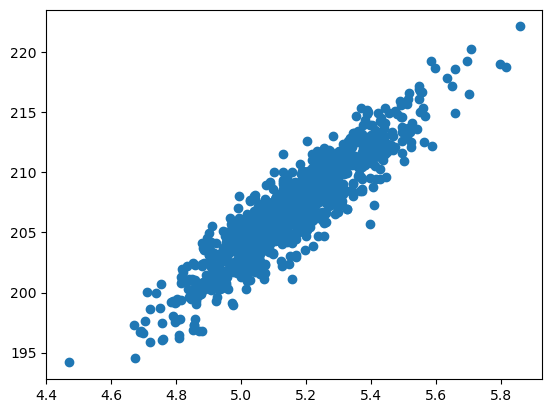

In [30]:
# Generate uniform random weights and plot
n_samples = 1000
n_locations = monthly_rev.shape[1]

w_np = np.random.uniform(size=(n_samples, n_locations))
w_np /= w_np.sum(axis=1, keepdims=True)
df_w = pd.DataFrame(w_np, columns=monthly_rev.columns)

df_plot = pd.DataFrame(data = [], index=df_w.index)
df_plot['cov'] =  df_w.apply(variance, axis=1, cov=cov)
df_plot['exp'] = df_w.apply(returns, axis=1, exp=exp)

plt.scatter(x=df_plot['cov'], y=df_plot['exp'])
plt.show()

In [31]:
# Compute 3 special points (min var, max sharpe, max returns)

ef = EfficientFrontier(exp, cov, weight_bounds=(0,1))
min_volatility_w = pd.Series((ef.min_volatility())) # ef.clean_weights()

ef = EfficientFrontier(exp, cov, weight_bounds=(0,1))
max_sharpe_w = pd.Series((ef.max_sharpe()))

max_returns_location = monthly_rev.sum().idxmax()
max_returns_w = {location: float(0) for location in max_sharpe_w.index}
max_returns_w[max_returns_location] = 1.0
max_returns_w = pd.Series(max_returns_w)

extremes_w = [min_volatility_w, max_sharpe_w, max_returns_w]
extremes_var = [variance(w, cov) for w in extremes_w]
extremes_exp = [returns(w, exp) for w in extremes_w]

In [32]:
# Compute points in boundary

boundary_range_exp = np.linspace(min(extremes_exp)+0.001, max(extremes_exp)-0.001, 100)
boundary_w = []

for boundary_exp in boundary_range_exp:
    ef = EfficientFrontier(exp, cov, weight_bounds=(0,1))
    w = pd.Series(ef.efficient_return(boundary_exp))
    boundary_w.append(w)

boundary_var = [variance(w, cov) for w in boundary_w]
boundary_exp = [returns(w, exp) for w in boundary_w]

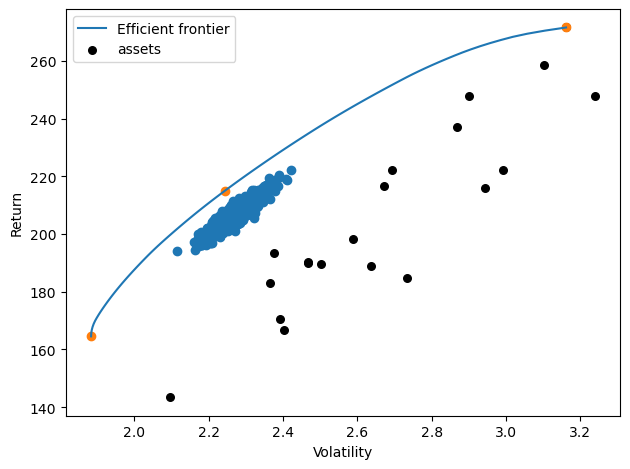

In [33]:
# Now we get more resonable picture TODO: see which linear convinations we get the blue curve.
ef = EfficientFrontier(exp, cov,  weight_bounds=(0,1))
fig, ax = plt.subplots()
plot_efficient_frontier(ef, ax=ax, show_assets=True)
plt.scatter(x=np.sqrt(df_plot['cov']), y=df_plot['exp'])
plt.scatter(np.sqrt(extremes_var), extremes_exp)
plt.show()

In [26]:
# TODO:
# - Get 3 special points
# - Get curve
# - Plot solutions on map nicely. 
# - 
# - compare minimum vairiance/sharpe with what one would get in specific location. How much improvement
# - Look correlations and see if we can get good result with fewer assets than boundary?
# 
#  utilitzar els 10 anys de preus? Fer model treient dades de vent reals i produccio?

In [108]:
#TODO: mirar si algunes estacions mai utilitzades en corva. 